In [7]:
from skreducedmodel.reducedbasis import ReducedBasis, error, normalize_set
import matplotlib.pyplot as plt
import numpy as np
import optuna

# Load Data

In [8]:
# physical points
times = np.linspace(-2750, 100, 28501)

# training set
filepath_train = "../../data/1d/1d_400_q_1_to_8.npy"
train = np.load(filepath_train)  
parameters_train = np.linspace(1, 8, train.shape[0])

# validation set
filepath_valid = "../../data/1d/1d_300_q_1_to_8.npy"
valid = normalize_set(np.load(filepath_valid), times)
parameters_valid = np.linspace(1, 8, valid.shape[0])

# test set
filepath_test = "../../data/1d/1d_200_q_1_to_8.npy"
test = normalize_set(np.load(filepath_test), times)
parameters_test = np.linspace(1, 8, test.shape[0])

# Optimize

In [9]:
from objective import Objective
from optuna.study import create_study
from optuna.samplers import TPESampler

hyperparameters = {"nmax" : [5, 15],
                   "lmax" : [0, 5],
                   "q_index" : [0, train.shape[0]-1],
                   "normalize" : True}

objective = Objective(times=times,
                      train=train,
                      valid=valid,
                      parameters_train=parameters_train,
                      parameters_valid=parameters_valid,
                      hyperparameters=hyperparameters)

study_name= f"simple-optimization-ts{train.shape[0]}-vs{valid.shape[0]}-normalized"

study = create_study(study_name=study_name,
                            storage="sqlite:///studies.db", 
                            load_if_exists=False,   # change to True to continue an existing study
                            sampler=TPESampler(n_startup_trials=10, 
                                               multivariate=True, 
                                               seed=12))

study.optimize(objective, n_trials=50, gc_after_trial=True)

[I 2023-10-13 11:45:42,291] A new study created in RDB with name: simple-optimization-ts400-vs300-normalized
[I 2023-10-13 11:45:45,741] Trial 0 finished with value: 9.479262485532674e-07 and parameters: {'nmax': 6, 'lmax': 4, 'q_index': 105}. Best is trial 0 with value: 9.479262485532674e-07.
[I 2023-10-13 11:45:47,278] Trial 1 finished with value: 0.815717725401032 and parameters: {'nmax': 10, 'lmax': 0, 'q_index': 367}. Best is trial 0 with value: 9.479262485532674e-07.
[I 2023-10-13 11:45:49,321] Trial 2 finished with value: 0.0010032023850518063 and parameters: {'nmax': 14, 'lmax': 0, 'q_index': 382}. Best is trial 0 with value: 9.479262485532674e-07.
[I 2023-10-13 11:45:50,949] Trial 3 finished with value: 0.8573101891896562 and parameters: {'nmax': 6, 'lmax': 1, 'q_index': 242}. Best is trial 0 with value: 9.479262485532674e-07.
[I 2023-10-13 11:45:55,002] Trial 4 finished with value: 7.631740911491143e-13 and parameters: {'nmax': 15, 'lmax': 5, 'q_index': 0}. Best is trial 4 wi

# Best hyperparameters Found

In [10]:
best_params = study.best_params; 
for param, value in best_params.items():
    print(f"Best {param} = {value}") 
    # the best seed is an index
print(f"Best Validation Error {study.best_value:.3e}")

Best lmax = 3
Best nmax = 14
Best q_index = 195
Best Validation Error 9.993e-14


### Test Error

In [11]:
rb_best = ReducedBasis(index_seed_global_rb=best_params["q_index"], 
                       lmax=best_params["lmax"], 
                       nmax=best_params["nmax"])
rb_best.fit(train, parameters_train, times)
projections_test = []
for h_t, q_t in zip(test, parameters_test):
    projections_test.append(rb_best.transform(h_t, q_t))
projections_test = np.asarray(projections_test)
test_errors = []

for h_proy, h_test in zip(projections_test, test):
    test_errors.append(error(h_proy, h_test, times))

print(f"Test Error (Max projection error) = {max(test_errors)}")

Test Error (Max projection error) = 6.899415351013532e-11


C:\Users\eliaz\AppData\Local\Temp\ipykernel_21588\3998284744.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(rb_best.tree.leaves))


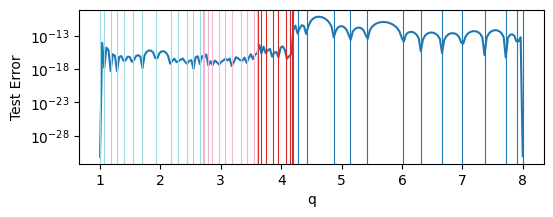

In [12]:
plt.figure(figsize=(6,2))
plt.plot(parameters_test, test_errors)
plt.yscale("log")
plt.ylabel("Test Error")
plt.xlabel("q")

colors = plt.cm.get_cmap('tab20', len(rb_best.tree.leaves))

for i, leaf in enumerate(rb_best.tree.leaves):
    color = colors(i)
    for p in leaf.train_parameters[leaf.indices]:
        plt.axvline(p,c=color,lw=.8)

# Visualize Optimization Results

### Hyperparameter Importances

In [13]:
optuna.visualization.plot_param_importances(study)

In [14]:
# dataframe with trials
db = study.trials_dataframe()

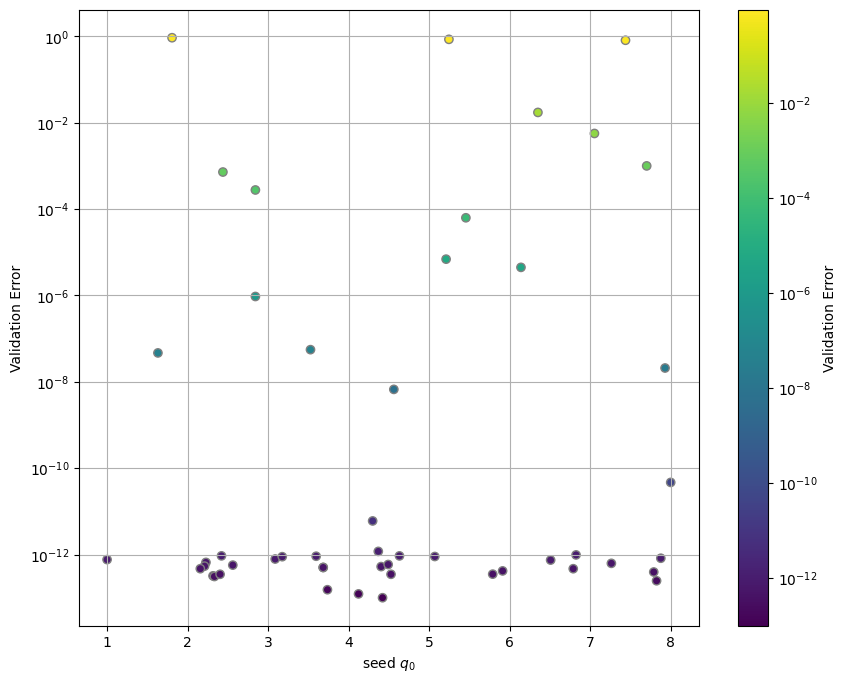

In [15]:
# seed
from matplotlib import colors

x = parameters_train[db.params_q_index]
y = db.value

norm = colors.LogNorm(min(db.value), max(db.value))
plt.figure(figsize=(10, 8))
plt.scatter(x, y, c= db.value, edgecolors="gray",norm=norm)
plt.grid()
plt.colorbar(label="Validation Error")
plt.xlabel(r"seed $q_0$")
plt.ylabel(r"Validation Error")
plt.yscale("log")

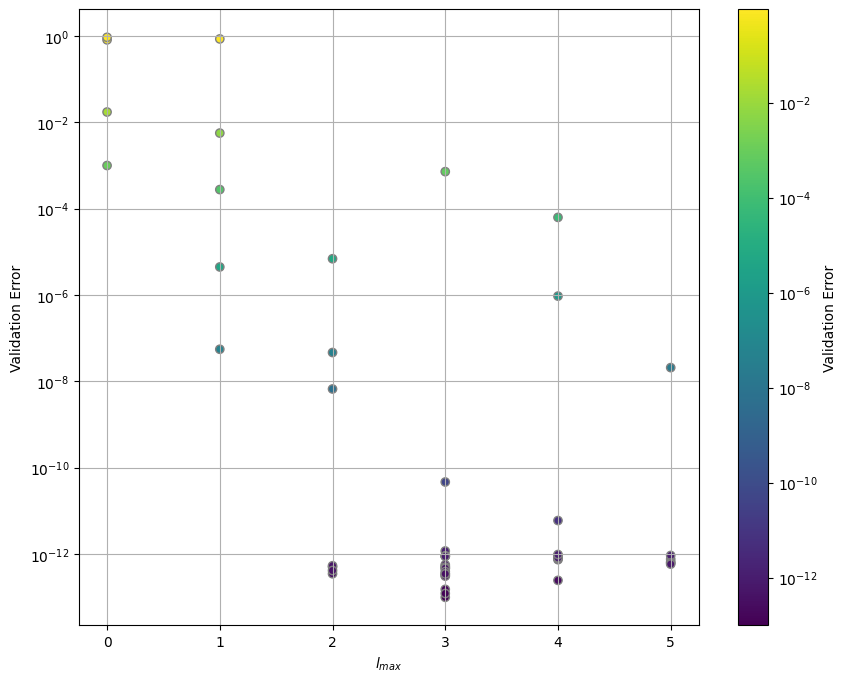

In [16]:
# seed
from matplotlib import colors

x = db.params_lmax
y = db.value

norm = colors.LogNorm(min(db.value), max(db.value))
plt.figure(figsize=(10, 8))
plt.scatter(x, y, c= db.value, edgecolors="gray",norm=norm)
plt.grid()
plt.colorbar(label="Validation Error")
plt.xlabel(r"$l_{max}$")
plt.ylabel(r"Validation Error")
plt.yscale("log")

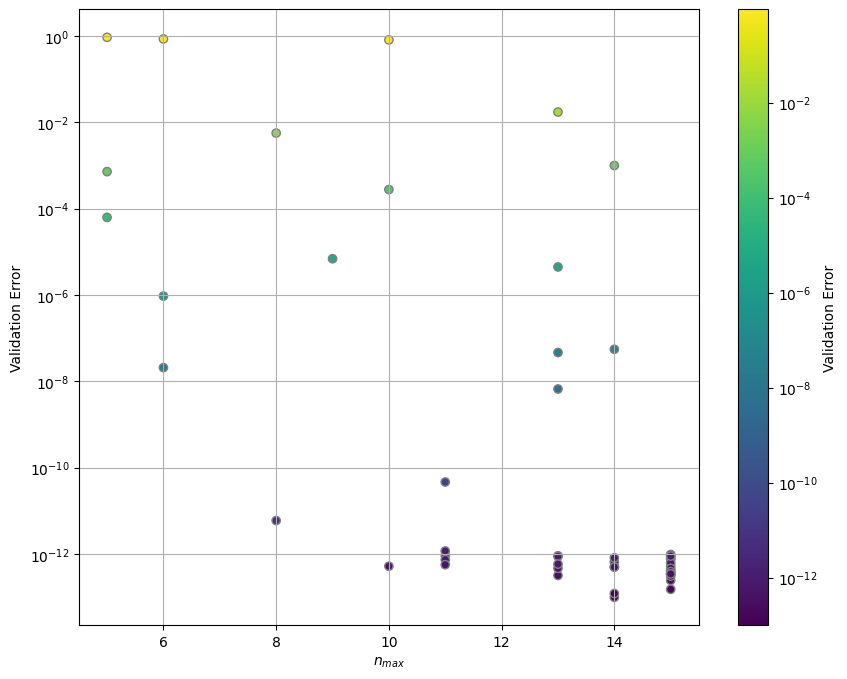

In [17]:
# seed
from matplotlib import colors

x = db.params_nmax
y = db.value

norm = colors.LogNorm(min(db.value), max(db.value))
plt.figure(figsize=(10, 8))
plt.scatter(x, y, c= db.value, edgecolors="gray",norm=norm)
plt.grid()
plt.colorbar(label="Validation Error")
plt.xlabel(r"$n_{max}$")
plt.ylabel(r"Validation Error")
plt.yscale("log")

### Evolution of Validation Error

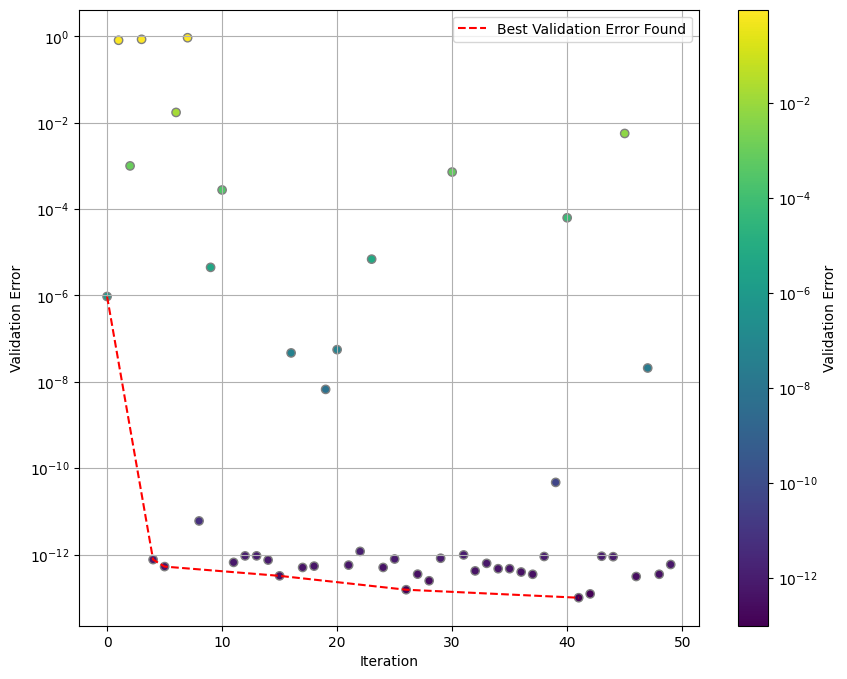

In [18]:
from matplotlib import colors

x = db.number
y = db.value

min_errs = [y[0]]
min_errs_it = [x[0]]
for i, err in enumerate(y):
    if err <= min(min_errs):
        min_errs.append(err)
        min_errs_it.append(x[i])

norm = colors.LogNorm(y.min(), y.max())
plt.figure(figsize=(10, 8))
plt.scatter(x, y, c=y, edgecolors="gray",norm=norm)
plt.plot(min_errs_it, min_errs, "r--", label="Best Validation Error Found")
plt.grid()
plt.colorbar(label="Validation Error")
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Validation Error")
plt.legend()

### Evolution of Hyperparameters

Text(0, 0.5, '$l_{max}$')

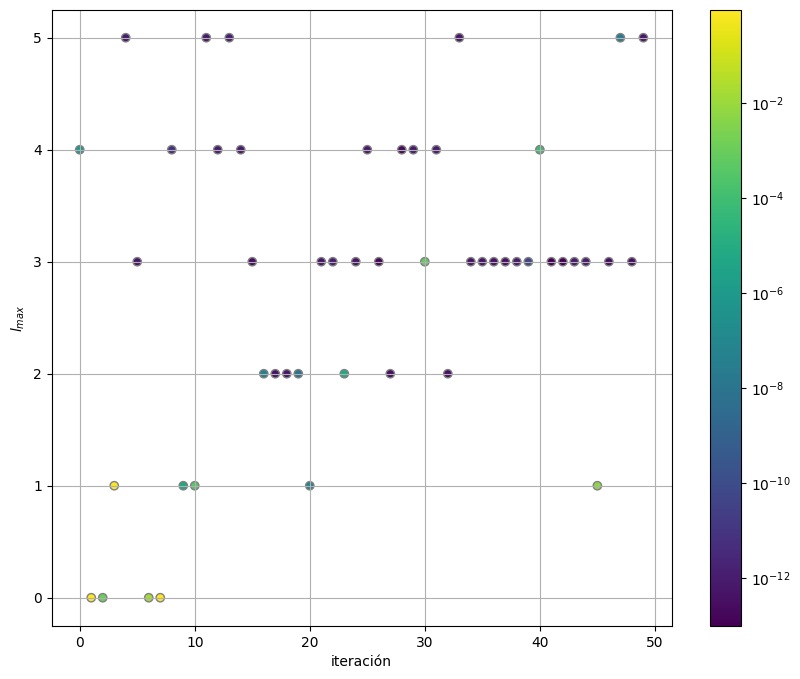

In [19]:
# lmax
x = db.number
y = db.params_lmax

norm = colors.LogNorm(min(db.value), max(db.value))
plt.figure(figsize=(10, 8))
plt.scatter(x, y, c= db.value, edgecolors="gray",norm=norm)
plt.grid()
plt.colorbar()
plt.xlabel("iteración")
plt.ylabel(r"$l_{max}$")

Text(0, 0.5, '$n_{max}$')

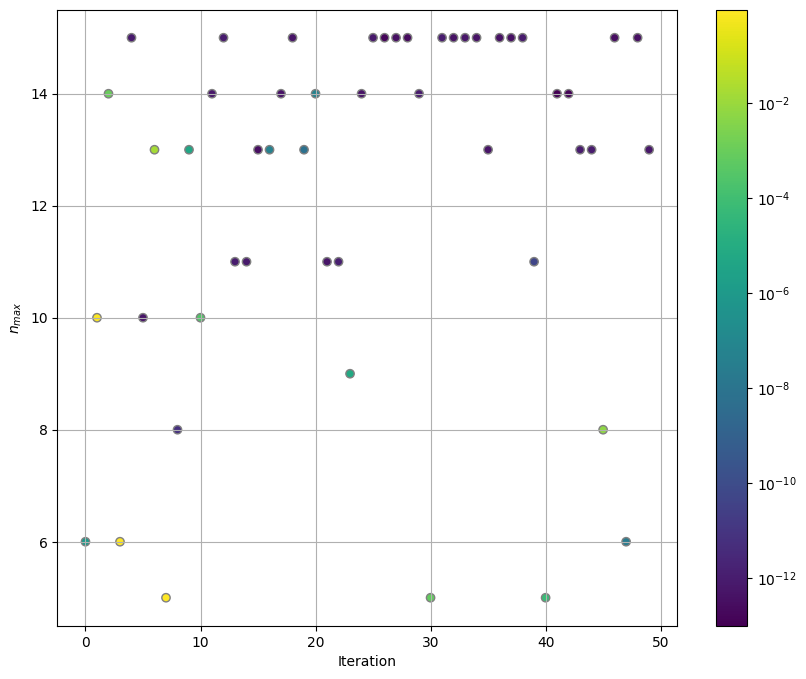

In [20]:
# n max
x = db.number
y = db.params_nmax

norm = colors.LogNorm(min(db.value), max(db.value))
plt.figure(figsize=(10, 8))
plt.scatter(x, y, c= db.value, edgecolors="gray",norm=norm)
plt.grid()
plt.colorbar()
plt.xlabel("Iteration")
plt.ylabel(r"$n_{max}$")

Text(0, 0.5, 'seed $q_0$')

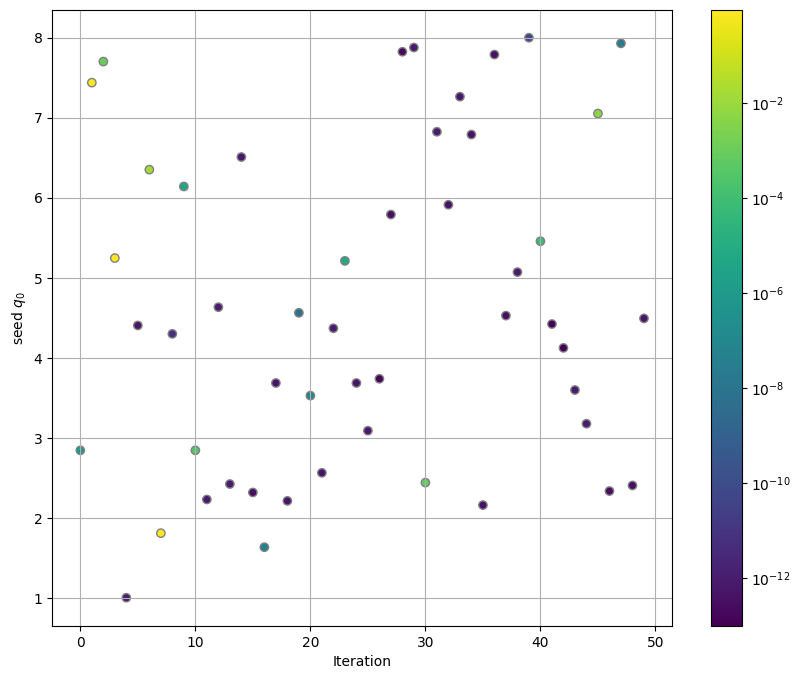

In [21]:
# seed q0
x = db.number
y = parameters_train[db.params_q_index]

norm = colors.LogNorm(min(db.value), max(db.value))
plt.figure(figsize=(10, 8))
plt.scatter(x, y, c= db.value, edgecolors="gray",norm=norm)
plt.grid()
plt.colorbar()
plt.xlabel("Iteration")
plt.ylabel(r"seed $q_0$")